In [2]:
#import the necessary libraries
import netCDF4 as nc4
from netCDF4 import Dataset
import numpy as np
import matplotlib.pyplot as plt
import os 
from scipy.io import netcdf

# Data Extraction

Array with strings path + file name

In [2]:
files_withDirectory=list()
# List all files in a directory using os.listdir
basepath = r"C:\Users\mitsy\OneDrive - Hanzehogeschool Groningen\master SSE\DFAM\data\All data" #C:\Users\User\gitHub\data (wkhalili)
for entry in os.listdir(basepath):
    files=os.path.join(basepath, entry)
    files_withDirectory.append(files) #paths for all the 81 NC files

In [3]:
len(files_withDirectory)

81

We have 81 nc files, 3 nc files per day. That means three orbits covering China 

In [4]:
# check the first file 
print(files_withDirectory[0])


C:\Users\mitsy\OneDrive - Hanzehogeschool Groningen\master SSE\DFAM\data\All data\S5P_OFFL_L2__CH4____20200501T031728_20200501T045858_13205_01_010302_20200502T194355.nc


We create here a list of dates of all the files, and a list of non repeated dates

In [5]:
# list all the dates of the files 
date_list=list()
for i in range (len(files_withDirectory)):
    split=files_withDirectory[i].split("T") #devides the name of the path+file every time it finds "T"
    date_list.append(split[1][7:15]) #list of dates of the 81 files
    

unique_date_list=list()
for i in date_list:
    if i not in unique_date_list:
        unique_date_list.append(i) #list of non repeated dates

In [6]:
print(len(date_list)) # dates of all the 81 files 
print(len(unique_date_list)) # 27 non repeated dates

81
27


Here a data list of the the 81 path + name strings is built. Its size is 27x3, the files belong to 3 different orbits (3 orbits per day)

In [7]:
data_array=np.empty([27,3],dtype = 'object')

row=0
column=0
for item in files_withDirectory:
    data_array[row,column]=item #fill the data_array with the 81 path+name strings
    column+=1
    if column==3:
        column=0
        row+=1

For the analysis we cover a big part of China

Here we stract the data from the file: latitudes, longitudes and methane mixing ratio. We store them in (27,3) arrays

In [8]:
Lons_array=np.empty([27,3],dtype = 'object')
Lats_array=np.empty([27,3],dtype = 'object')
CH4_array=np.empty([27,3],dtype = 'object')
China_lat=list()
China_lon=list()
China_CH4_concentration=list()


for i,rows in enumerate(data_array):
    for j,column in enumerate(rows):      
        opened_file = Dataset(column, mode='r')
        Lons_array[i,j]= opened_file.groups['PRODUCT'].variables['longitude'][:][0,:,:] # (4172,215). 896,980 longitud ‬values for every one of the 81 files
        Lats_array[i,j] = opened_file.groups['PRODUCT'].variables['latitude'][:][0,:,:] # (4172,215). 896,980 latitude ‬values for every one of the 81 files
        CH4_array [i,j]= opened_file.groups['PRODUCT'].variables['methane_mixing_ratio'][0,:,:] # (4172,215). 896,980 methane_mixing_ratio ‬values for every one of the 81 files
        fill_val=opened_file.groups['PRODUCT'].variables['methane_mixing_ratio_bias_corrected']._FillValue #comment: This value will be filled with data after the commissioning phase, this is known to be empty for now. We just use the fill value of 9.96921e+36 for all the 81 files 


# Data visualization

# China

The area chosen is a rectangle that covers a big part of China

In [12]:
import numpy as np
from matplotlib import pyplot as plt
import cv2

# Load an color image in grayscale
img = cv2.imread('pictures of maps/rectangle_China.png',cv2.IMREAD_UNCHANGED)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

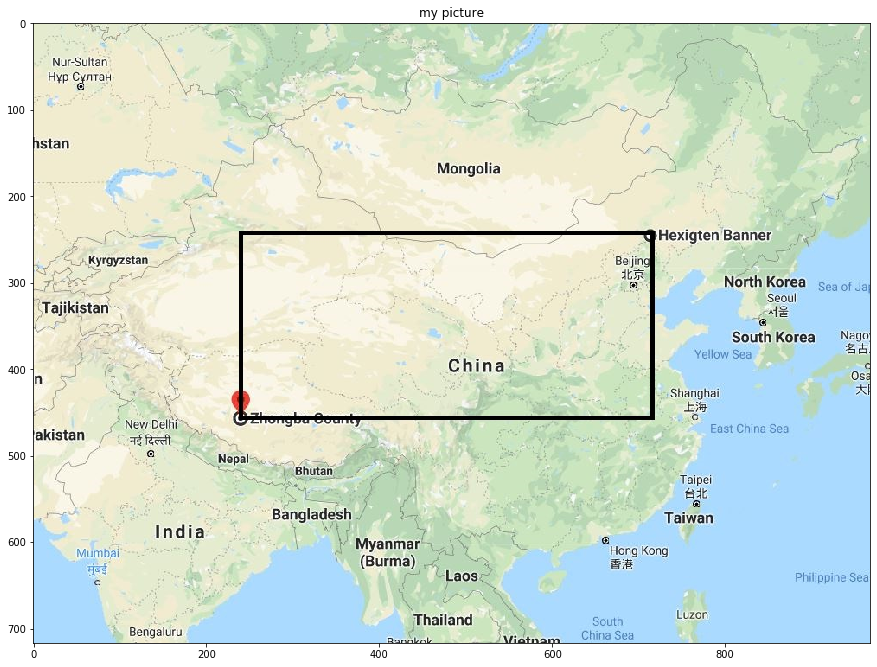

In [13]:
plt.figure(figsize=(15, 15))
plt.imshow(img)
plt.title('my picture')
plt.show()

In [14]:
min_Latitude,max_Latitude = 31.160352,42.967835
min_Longitude,max_Longitude = 84.476644,117.78719

Here we build the CH4, latitude and longitud lists for the are in study and for the period of one month

In [15]:
# I want to specify the latitud, longtitude and CH4 concentration for China district from the data retrieved per day

china_lat_array_index=list()
china_lon_array_index=list()
flattend_CH4_month=list()
defined_china_lat_month=list()
defined_china_lon_month=list()

for i in range(Lats_array.shape[0]): #27 days of data. 
     
    flattend_latitude=np.concatenate((Lats_array[i,0].flatten(),Lats_array[i,1].flatten(),Lats_array[i,2].flatten())) #2597630 latitude values for each day
    flattend_longitude=np.concatenate((Lons_array[i,0].flatten(),Lons_array[i,1].flatten(),Lons_array[i,2].flatten())) #2597630 longitude values for each day
    CH4_array_flattened=np.concatenate((CH4_array [i,0].flatten(),CH4_array [i,1].flatten(),CH4_array [i,2].flatten())) #2597630 CH4 values for each day           

    # each orbit has 3000 scanlines, to specify the region of China scalines.using the lat, and lon of 
    # china district from the retrieved data,and then find Ch4 amount in within that area of              #
    # the defined longtitude and latitude                                                                  #


    china_scanlines=(np.where(flattend_latitude>min_Latitude) and (np.where(flattend_latitude<max_Latitude)))[0] # here we take the position of the flattend_latitude array that satisfy these conditions

    defined_china_lat_day=list()
    defined_china_lon_day=list()
    flattend_CH4_day= list()
    for item in china_scanlines:
        # whithin the latitude and longtitude and the values of CH4 not more 2200ppb ,fill_val approximately = 9.9 e36
        if  flattend_longitude[item]>min_Longitude and flattend_longitude[item]<max_Longitude and CH4_array_flattened[item] !=fill_val:
            flattend_CH4_day.append(CH4_array_flattened[item])
            defined_china_lat_day.append(flattend_latitude[item])
            defined_china_lon_day.append(flattend_longitude[item])
            
    flattend_CH4_month.append(flattend_CH4_day)
    defined_china_lat_month.append(defined_china_lat_day)
    defined_china_lon_month.append(defined_china_lon_day)



Here we calculate average of each day, percetile, minimum and maximum of each day, and standard deviation

In [16]:
#####################################################################
# flattend_CH4_month, row are days                                  #
# calculating the average of CH4 per day and append them in array  #
# calculating the second percent of the maximum value per day       #
# find the maximum value of ch4 per day                             #
#####################################################################
CH4_average=list()
percetile_array=list()
ch4_max_array=list()
ch4_min_array=list()
ch4_standard_deviation=list()

for i in range(len(flattend_CH4_month)):
    CH4_average.append(np.mean(flattend_CH4_month[i]))
    CH4_sorted=np.sort(flattend_CH4_month[i]) 
    percetile_array.append(np.percentile(CH4_sorted,95))
    ch4_max_array.append(np.max(flattend_CH4_month[i]))
    ch4_standard_deviation.append(np.std(flattend_CH4_month[i]))

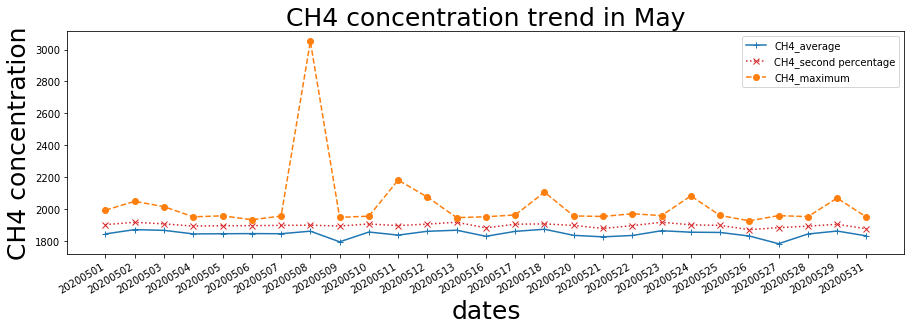

In [17]:
# visualizing CH4 trends during May (a few days where missing because the files where corrupted)
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(15,10))
plt.subplot(211)
plt.plot(unique_date_list,CH4_average,  color='tab:blue', marker='+',label="CH4_average")
plt.plot(unique_date_list,percetile_array, color='tab:red',marker='x',linestyle=':',label="CH4_second percentage")
plt.plot(unique_date_list,ch4_max_array ,color='tab:orange',marker='o',linestyle='--',label="CH4_maximum")

plt.xlabel("dates",fontsize=25)
plt.ylabel("CH4 concentration",fontsize=25)
plt.title("CH4 concentration trend in May",fontsize=25)
plt.gcf().autofmt_xdate()
plt.legend(fontsize=10)

plt.show()


The maximum value gives us more interesting information because even though it shoes the methane value for a spacific point inside the rectangle it shows an abnormal methane leakage

We can see that there is a pick on the CH4_maximum line between the 7th and the 9th of May, this might reflect the contruction incident with date 6th of May in coordinates 40.820417, 111.662833 (see gas_leakage_incident.xlsx)

We can narrow the area of  interest to show CH4 indicents from the gas_leakage_incident.xlsx document

# China 06-05-2020

**tropomi project-CH4 average.ipynb**

This notebook plots in graphs the average, second percentage and maximum CH4 concentrations in parts per billion. The following areas are used for analysing the data that is plotted in graphs in the order:

- Big rectangular area covering a big portion of China
- Area of each incident listed in gas_leakage_incident.xlsx in the same order

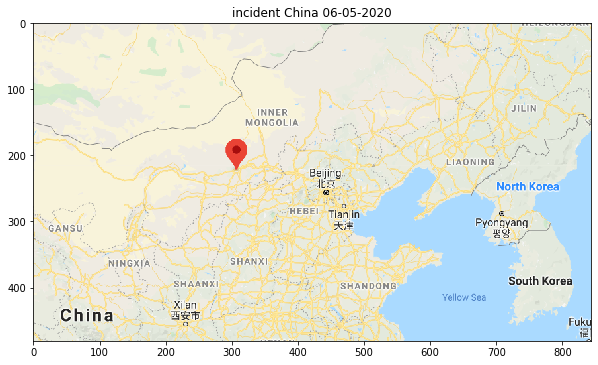

In [6]:
import numpy as np
from matplotlib import pyplot as plt
import cv2

# Load an color image in grayscale
img = cv2.imread('pictures of maps/map_incident_06052020.PNG',cv2.IMREAD_UNCHANGED)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.title('incident China 06-05-2020')
plt.show()

The accident occured in coordinates 40.820417, 111.662833 (shown in the map). The area of study is defined by the following coordinates:

In [10]:
min_Latitude,max_Latitude = 39 , 42
min_Longitude,max_Longitude = 110 , 113

In [11]:
# I want to specify the latitud, longtitude and CH4 concentration for China district from the data retrieved per day

china_lat_array_index=list()
china_lon_array_index=list()
flattend_CH4_month=list()
defined_china_lat_month=list()
defined_china_lon_month=list()

for i in range(Lats_array.shape[0]): #27 days of data. 
     
    flattend_latitude=np.concatenate((Lats_array[i,0].flatten(),Lats_array[i,1].flatten(),Lats_array[i,2].flatten())) #2597630 latitude values for each day
    flattend_longitude=np.concatenate((Lons_array[i,0].flatten(),Lons_array[i,1].flatten(),Lons_array[i,2].flatten())) #2597630 longitude values for each day
    CH4_array_flattened=np.concatenate((CH4_array [i,0].flatten(),CH4_array [i,1].flatten(),CH4_array [i,2].flatten())) #2597630 CH4 values for each day           

    # each orbit has 3000 scanlines, to specify the region of China scalines.using the lat, and lon of 
    # china district from the retrieved data,and then find Ch4 amount in within that area of              #
    # the defined longtitude and latitude                                                                  #


    china_scanlines=(np.where(flattend_latitude>min_Latitude) and (np.where(flattend_latitude<max_Latitude)))[0] # here we take the position of the flattend_latitude array that satisfy these conditions

    defined_china_lat_day=list()
    defined_china_lon_day=list()
    flattend_CH4_day= list()
    for item in china_scanlines:
        # whithin the latitude and longtitude and the values of CH4 not more 2200ppb ,fill_val approximately = 9.9 e36
        if  flattend_longitude[item]>min_Longitude and flattend_longitude[item]<max_Longitude and CH4_array_flattened[item] !=fill_val:
            flattend_CH4_day.append(CH4_array_flattened[item])
            defined_china_lat_day.append(flattend_latitude[item])
            defined_china_lon_day.append(flattend_longitude[item])
            
    flattend_CH4_month.append(flattend_CH4_day)
    defined_china_lat_month.append(defined_china_lat_day)
    defined_china_lon_month.append(defined_china_lon_day)



In [13]:
#####################################################################
# flattend_CH4_month, row are days                                  #
# calculating the average of CH4 per day and append them in array  #
# calculating the second percent of the maximum value per day       #
# find the maximum value of ch4 per day                             #
#####################################################################
CH4_average=list()
percetile_array=list()
ch4_max_array=list()
ch4_min_array=list()
ch4_standard_deviation=list()

for i in range(len(flattend_CH4_month)):
    CH4_average.append(np.mean(flattend_CH4_month[i]))
    CH4_sorted=np.sort(flattend_CH4_month[i]) 
    #percetile_array.append(np.percentile(CH4_sorted,95))
    ch4_max_array.append(np.max(flattend_CH4_month[i]))
    ch4_standard_deviation.append(np.std(flattend_CH4_month[i]))

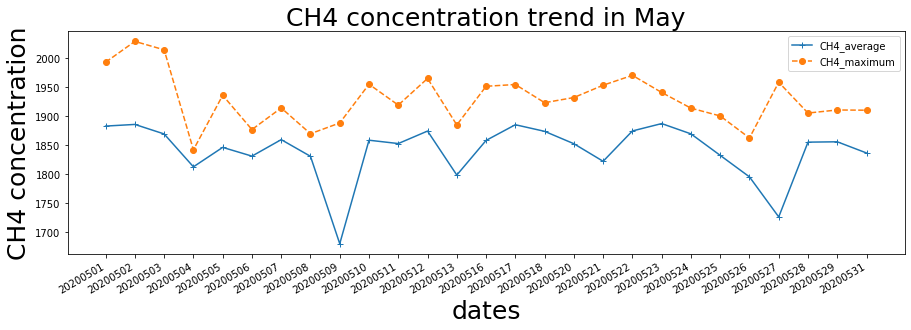

In [14]:
# visualizing CH4 trends during May (a few days where missing because the files where corrupted)
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(15,10))
plt.subplot(211)
plt.plot(unique_date_list,CH4_average,  color='tab:blue', marker='+',label="CH4_average")
#plt.plot(unique_date_list,percetile_array, color='tab:red',marker='x',linestyle=':',label="CH4_second percentage")
plt.plot(unique_date_list,ch4_max_array ,color='tab:orange',marker='o',linestyle='--',label="CH4_maximum")

plt.xlabel("dates",fontsize=25)
plt.ylabel("CH4 concentration",fontsize=25)
plt.title("CH4 concentration trend in May",fontsize=25)
plt.gcf().autofmt_xdate()
plt.legend(fontsize=10)

plt.show()


# China 26-27/05/2020

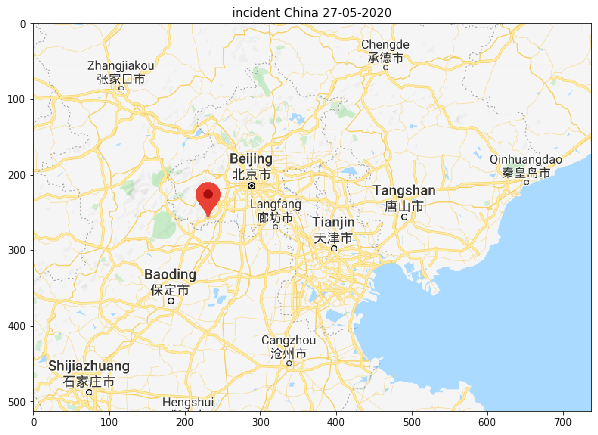

In [23]:
import numpy as np
from matplotlib import pyplot as plt
import cv2

# Load an color image in grayscale
img = cv2.imread('pictures of maps/map_incident26-27_5.PNG',cv2.IMREAD_UNCHANGED)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.title('incident China 27-05-2020')
plt.show()

In [94]:
min_Latitude,max_Latitude = 38 , 41
min_Longitude,max_Longitude = 114 , 117

In [95]:
files_withDirectory=list()
# List all files in a directory using os.listdir
basepath = r"C:\Users\mitsy\OneDrive - Hanzehogeschool Groningen\master SSE\DFAM\data\All data" #C:\Users\User\gitHub\data (wkhalili)
for entry in os.listdir(basepath):
    files=os.path.join(basepath, entry)
    files_withDirectory.append(files) #paths for all the 81 NC files

In [96]:
# list all the dates of the files 
date_list=list()
for i in range (len(files_withDirectory)):
    split=files_withDirectory[i].split("T") #devides the name of the path+file every time it finds "T"
    date_list.append(split[1][7:15]) #list of dates of the 81 files
    

unique_date_list=list()
for i in date_list:
    if i not in unique_date_list:
        unique_date_list.append(i) #list of non repeated dates


In [97]:
data_array=np.empty([27,3],dtype = 'object')

row=0
column=0
for item in files_withDirectory:
    data_array[row,column]=item #fill the data_array with the 81 path+name strings
    column+=1
    if column==3:
        column=0
        row+=1

In [98]:
Lons_array=np.empty([27,3],dtype = 'object')
Lats_array=np.empty([27,3],dtype = 'object')
CH4_array=np.empty([27,3],dtype = 'object')
China_lat=list()
China_lon=list()
China_CH4_concentration=list()


for i,rows in enumerate(data_array):
    for j,column in enumerate(rows):      
        opened_file = Dataset(column, mode='r')
        Lons_array[i,j]= opened_file.groups['PRODUCT'].variables['longitude'][:][0,:,:] # (4172,215). 896,980 longitud ‬values for every one of the 81 files
        Lats_array[i,j] = opened_file.groups['PRODUCT'].variables['latitude'][:][0,:,:] # (4172,215). 896,980 latitude ‬values for every one of the 81 files
        CH4_array [i,j]= opened_file.groups['PRODUCT'].variables['methane_mixing_ratio'][0,:,:] # (4172,215). 896,980 methane_mixing_ratio ‬values for every one of the 81 files
        fill_val=opened_file.groups['PRODUCT'].variables['methane_mixing_ratio_bias_corrected']._FillValue #comment: This value will be filled with data after the commissioning phase, this is known to be empty for now. We just use the fill value of 9.96921e+36 for all the 81 files 


In [99]:
# I want to specify the latitud, longtitude and CH4 concentration for China district from the data retrieved per day

china_lat_array_index=list()
china_lon_array_index=list()
flattend_CH4_month=list()
defined_china_lat_month=list()
defined_china_lon_month=list()

for i in range(Lats_array.shape[0]): #27 days of data. 
     
    flattend_latitude=np.concatenate((Lats_array[i,0].flatten(),Lats_array[i,1].flatten(),Lats_array[i,2].flatten())) #2597630 latitude values for each day
    flattend_longitude=np.concatenate((Lons_array[i,0].flatten(),Lons_array[i,1].flatten(),Lons_array[i,2].flatten())) #2597630 longitude values for each day
    CH4_array_flattened=np.concatenate((CH4_array [i,0].flatten(),CH4_array [i,1].flatten(),CH4_array [i,2].flatten())) #2597630 CH4 values for each day           

    # each orbit has 3000 scanlines, to specify the region of China scalines.using the lat, and lon of 
    # china district from the retrieved data,and then find Ch4 amount in within that area of              #
    # the defined longtitude and latitude                                                                  #


    china_scanlines=(np.where(flattend_latitude>min_Latitude) and (np.where(flattend_latitude<max_Latitude)))[0] # here we take the position of the flattend_latitude array that satisfy these conditions

    defined_china_lat_day=list()
    defined_china_lon_day=list()
    flattend_CH4_day= list()
    for item in china_scanlines:
        # whithin the latitude and longtitude and the values of CH4 not more 2200ppb ,fill_val approximately = 9.9 e36
        if  flattend_longitude[item]>min_Longitude and flattend_longitude[item]<max_Longitude and CH4_array_flattened[item] !=fill_val:
            flattend_CH4_day.append(CH4_array_flattened[item])
            defined_china_lat_day.append(flattend_latitude[item])
            defined_china_lon_day.append(flattend_longitude[item])
            
    flattend_CH4_month.append(flattend_CH4_day)
    defined_china_lat_month.append(defined_china_lat_day)
    defined_china_lon_month.append(defined_china_lon_day)


In [101]:
#####################################################################
# flattend_CH4_month, rows are days                                  #
# calculating the average of CH4 per day and append them in array  #
# calculating the second percent of the maximum value per day       #
# find the maximum value of ch4 per day                             #

CH4_average=list()
percetile_array=list()
ch4_max_array=list()
ch4_min_array=list()
ch4_standard_deviation=list()

for i in range(len(flattend_CH4_month)):
    CH4_average.append(np.mean(flattend_CH4_month[i]))
    CH4_sorted=np.sort(flattend_CH4_month[i]) 
    percetile_array.append(np.percentile(CH4_sorted,95))
    ch4_max_array.append(np.max(flattend_CH4_month[i]))
    ch4_standard_deviation.append(np.std(flattend_CH4_month[i]))

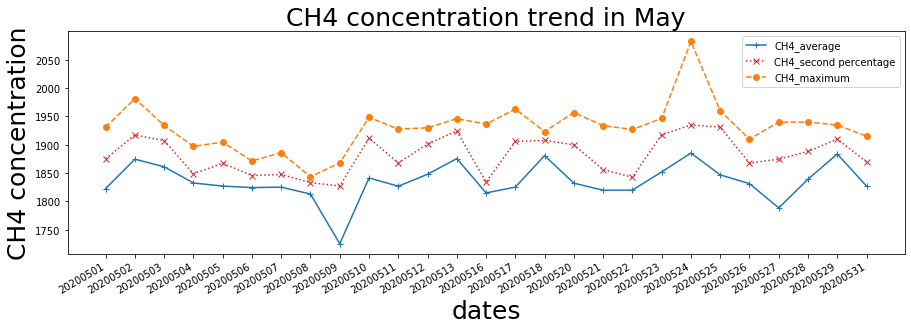

In [102]:
# visualizing CH4 trends during May (a few days where missing because the files where corrupted)
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(15,10))
plt.subplot(211)
plt.plot(unique_date_list,CH4_average,  color='tab:blue', marker='+',label="CH4_average")
plt.plot(unique_date_list,percetile_array, color='tab:red',marker='x',linestyle=':',label="CH4_second percentage")
plt.plot(unique_date_list,ch4_max_array ,color='tab:orange',marker='o',linestyle='--',label="CH4_maximum")

plt.xlabel("dates",fontsize=25)
plt.ylabel("CH4 concentration",fontsize=25)
plt.title("CH4 concentration trend in May",fontsize=25)
plt.gcf().autofmt_xdate()
plt.legend(fontsize=10)

plt.show()